# Evaluation of ReInspect

Evaluation for end-to-end people detection in crowded scenes.

Let's start with importing the required files, seeding the random number generators and setting up the hyperparameters.

In [1]:
import cv2
import json
import numpy as np
import copy
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import imread
from IPython import display
import caffe
import apollocaffe # Make sure that caffe is on the python path:

from utils.annolist import AnnotationLib as al
from train import load_idl, forward
from utils import load_data_mean, Rect, stitch_rects

In [2]:
config = json.load(open("config.json", 'r'))
# config["data"]["test_idl"] = "./second_carteen/annnotation/2015_1230_114054_026.idl"
config["data"]["test_idl"] = "./data/brainwash/brainwash_test.idl"

apollocaffe.set_random_seed(config["solver"]["random_seed"])
apollocaffe.set_device(0)

2016-04-30 11:11:35 - GPU device 0


Now lets load the data mean and the data.

In [3]:
data_mean = load_data_mean(config["data"]["idl_mean"], 
                           config["net"]["img_width"], 
                           config["net"]["img_height"], image_scaling=1.0)

num_test_images = 20

# Warning: load_idl returns an infinite generator. Calling list() before islice() will hang.
test_list = list(itertools.islice(
        load_idl(config["data"]["test_idl"], data_mean, config["net"], False),
        0,
        num_test_images))

We can now load the snapshot weights.

In [4]:
net = apollocaffe.ApolloNet()
net.phase = 'test'
forward(net, test_list[0], config["net"], True)
net.load("./data/brainwash_800000.h5")

We can now begin to run the model and visualize the results.

In [5]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

inception_4b/pool	(1, 512, 30, 40)
inception_5a/1x1	(1, 256, 15, 20)
inception_4d/pool	(1, 512, 30, 40)
inception_4c/3x3	(1, 256, 30, 40)
inception_3b/output	(1, 480, 60, 80)
pool1/3x3_s2	(1, 64, 120, 160)
lstm_hidden_seed	(300, 250)
ip_bbox1	(300, 4, 1, 1)
ip_bbox0	(300, 4, 1, 1)
ip_bbox3	(300, 4, 1, 1)
ip_bbox2	(300, 4, 1, 1)
inception_4e/output	(1, 832, 30, 40)
ip_bbox4	(300, 4, 1, 1)
inception_4e/1x1	(1, 256, 30, 40)
inception_3a/1x1	(1, 64, 60, 80)
inception_3b/3x3	(1, 192, 60, 80)
inception_5b/pool	(1, 832, 15, 20)
lstm_mem_seed	(300, 250)
inception_4e/5x5_reduce	(1, 32, 30, 40)
bbox_concat	(300, 4, 5, 1)
inception_4e/3x3	(1, 320, 30, 40)
lstm_fc7_conv	(1, 1024, 15, 20)
inception_3a/5x5	(1, 32, 60, 80)
inception_4d/5x5	(1, 64, 30, 40)
inception_3b/3x3_reduce	(1, 128, 60, 80)
inception_4d/3x3	(1, 288, 30, 40)
inception_3a/pool	(1, 192, 60, 80)
inception_5b/5x5_reduce	(1, 48, 15, 20)
inception_3a/pool_proj	(1, 32, 60, 80)
lstm_hidden2	(300, 250)
ip_bbox_unscaled4	(300, 4, 1, 1)
inc

In [7]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param.data.shape)

ip_bbox_unscaled0.p1	(4,)
ip_bbox_unscaled0.p0	(4, 250)
inception_4b/5x5_reduce.p0	(24, 512, 1, 1)
inception_4b/5x5_reduce.p1	(24,)
input_value	(1, 250, 1, 1274)
conv1/7x7_s2.p1	(64,)
conv1/7x7_s2.p0	(64, 3, 7, 7)
output_gate	(1, 250, 1, 1274)
inception_5b/pool_proj.p1	(128,)
inception_5b/pool_proj.p0	(128, 832, 1, 1)
forget_gate	(1, 250, 1, 1274)
inception_4d/3x3_reduce.p0	(144, 512, 1, 1)
inception_4d/3x3_reduce.p1	(144,)
inception_5a/3x3.p0	(320, 160, 3, 3)
inception_5a/3x3.p1	(320,)
ip_bbox_unscaled2.p1	(4,)
ip_bbox_unscaled2.p0	(4, 250)
ip_conf3.p0	(2, 250)
ip_conf3.p1	(2,)
inception_4a/1x1.p1	(192,)
inception_4a/1x1.p0	(192, 480, 1, 1)
inception_4c/5x5.p1	(64,)
inception_4c/5x5.p0	(64, 24, 5, 5)
inception_4e/5x5.p1	(128,)
inception_4e/5x5.p0	(128, 32, 5, 5)
inception_4a/5x5_reduce.p1	(16,)
inception_4a/5x5_reduce.p0	(16, 480, 1, 1)
ip_conf1.p0	(2, 250)
ip_conf1.p1	(2,)
ip_conf0.p0	(2, 250)
inception_4c/1x1.p1	(128,)
inception_4c/1x1.p0	(128, 512, 1, 1)
inception_3b/3x3_reduce.p1	

In [15]:
print net.params['ip_bbox_unscaled4.p0'].data

[[  2.61174235e-03   2.08082497e-02  -3.07209231e-02  -1.07122269e-02
    5.97484130e-03   1.90195236e-02   3.52439401e-03   1.52649754e-03
    3.52408066e-02  -1.67703227e-04   1.49601651e-02   4.57041810e-04
    1.11114020e-02  -9.82629787e-03  -3.57079245e-02  -1.93495452e-02
   -3.54816653e-02  -1.96215641e-02   8.91082268e-03   2.91047953e-02
   -7.95380305e-03   2.17987355e-02  -1.24940807e-02  -6.21174788e-03
   -2.01965105e-02   1.30741671e-02  -3.56131904e-02  -7.95688014e-03
    1.15352431e-02   4.21598703e-02   1.17861172e-02   4.15567076e-03
    3.61551158e-03   1.33900214e-02   8.78956821e-03   3.53997061e-03
    3.32022421e-02   3.02697308e-02  -5.08592576e-02   2.39791274e-02
    7.35581387e-03  -1.09620914e-02  -3.68829593e-02   6.70882175e-03
    1.10417232e-01   1.10568397e-01  -1.93668716e-02   3.18630878e-03
    6.97974209e-03   1.37627637e-02  -3.37009621e-03   2.97019514e-03
    2.45607868e-02  -5.60958823e-03   3.27357426e-02   1.77962724e-02
   -2.60152575e-02  

In [11]:
print net.params['ip_conf2.p1'].data

[ 0.74792069 -0.74792743]


(480, 640, 3)
10


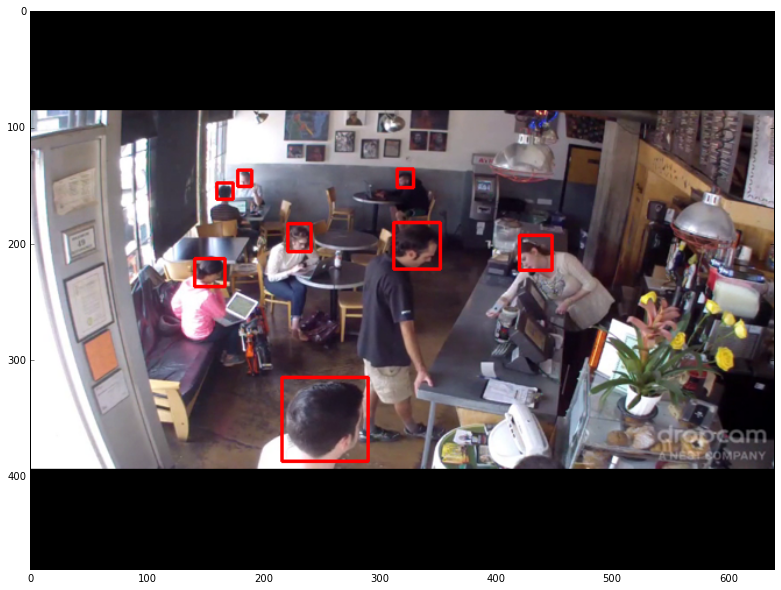

In [8]:
annolist = al.AnnoList()
net_config = config["net"]
pix_per_w = net_config["img_width"]/net_config["grid_width"]
pix_per_h = net_config["img_height"]/net_config["grid_height"]

for i in range(1):
    inputs = test_list[i]
    bbox_list, conf_list = forward(net, inputs, net_config, True)
    
    img = np.copy(inputs["raw"])
    print img.shape
    png = np.copy(inputs["imname"])
    all_rects = [[[] for x in range(net_config["grid_width"])] for y in range(net_config["grid_height"])]
    for n in range(len(bbox_list)):
        for k in range(net_config["grid_height"] * net_config["grid_width"]):
            y = int(k / net_config["grid_width"])
            x = int(k % net_config["grid_width"])
            bbox = bbox_list[n][k]
            conf = conf_list[n][k,1].flatten()[0]
            abs_cx = pix_per_w/2 + pix_per_w*x + int(bbox[0,0,0])
            abs_cy = pix_per_h/2 + pix_per_h*y+int(bbox[1,0,0])
            w = bbox[2,0,0]
            h = bbox[3,0,0]
            all_rects[y][x].append(Rect(abs_cx,abs_cy,w,h,conf))

    acc_rects = stitch_rects(all_rects, net_config)
#     acc_rects = []
#     for i in range(0, net_config["grid_height"], 1):
#         for j in range(0, net_config["grid_width"], 1):
#             for r in all_rects[i][j]:
#                 acc_rects.append(r)
    print len(acc_rects)
    
    conf_list = []
    for rect in acc_rects:
        conf_list.append(rect.true_confidence)
    conf_list = sorted(conf_list, reverse=True)  
    
    
    display = True
    if display:
        conf_thres = [1.0, 0.9 ]
        for ci in range(len(conf_thres)-1):
            thres_max = conf_thres[ci]
            thres_min = conf_thres[ci+1]
            c_img = copy.deepcopy(img)
            for rect in acc_rects:
                if rect.true_confidence <= thres_max and rect.true_confidence > thres_min:
                    cv2.rectangle(c_img, 
                              (rect.cx-int(rect.width/2), rect.cy-int(rect.height/2)), 
                              (rect.cx+int(rect.width/2), rect.cy+int(rect.height/2)), 
                              (255,0,0),
                              2)

            plt.figure(figsize=(15,10))
            plt.imshow(c_img)
        
        

In [23]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

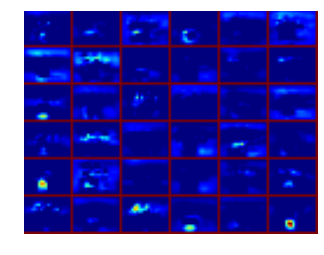

In [24]:
feat = net.blobs['inception_5b/5x5'].data[0, :36]
vis_square(feat)